# **Project Overview: Retail Company Warehouse Simulation**

**Scenario:**

* A retail warehouse receives orders randomly (every ~5 minutes, exponential distribution).

* The warehouse has 3 workers (resources) who pick and pack orders.

* Each order takes 4–8 minutes to process (uniform distribution).

* The warehouse has an inventory of 1000 items, and each order consumes 1–5 items (uniform distribution).

* If inventory drops below 100 items, a restock of 500 items occurs after a 10-minute delay.

* The simulation runs for 480 minutes (8 hours, a typical workday) and tracks:

  * Order processing times (time from arrival to completion).

  * Queue lengths (number of orders waiting).

  * Inventory levels over time.

* Outputs include console logs, statistics (average/max processing time, average queue length), and matplotlib plots.


**Objectives:**

* Simulate warehouse operations to analyze worker efficiency and inventory management.

* Ensure robust execution with error handling and data consistency.

* Provide visualizations for insights into bottlenecks and inventory dynamics.

**Environment:** Google Colab, using simpy, numpy, and matplotlib.

In [ ]:
# Install SimPy
!pip install simpy

Order0 arrived at 5.10, waited 0.00 minutes
Order1 arrived at 5.23, waited 0.00 minutes
Order2 arrived at 5.98, waited 0.00 minutes
Order0 processed in 4.98 minutes, left at 10.08, inventory: 995
Order1 processed in 6.71 minutes, left at 11.93, inventory: 995
Order2 processed in 6.36 minutes, left at 12.34, inventory: 995
Order3 arrived at 17.11, waited 0.00 minutes
Order4 arrived at 17.28, waited 0.00 minutes
Order5 arrived at 20.80, waited 0.00 minutes
Order3 processed in 4.87 minutes, left at 21.99, inventory: 988
Order4 processed in 6.24 minutes, left at 23.52, inventory: 988
Order5 processed in 5.68 minutes, left at 26.47, inventory: 988
Order6 arrived at 27.09, waited 0.00 minutes
Order7 arrived at 30.07, waited 0.00 minutes
Order8 arrived at 30.10, waited 0.00 minutes
Order6 processed in 7.24 minutes, left at 34.33, inventory: 981
Order9 arrived at 32.18, waited 2.14 minutes
Order8 processed in 4.86 minutes, left at 34.97, inventory: 980
Order7 processed in 6.79 minutes, left at

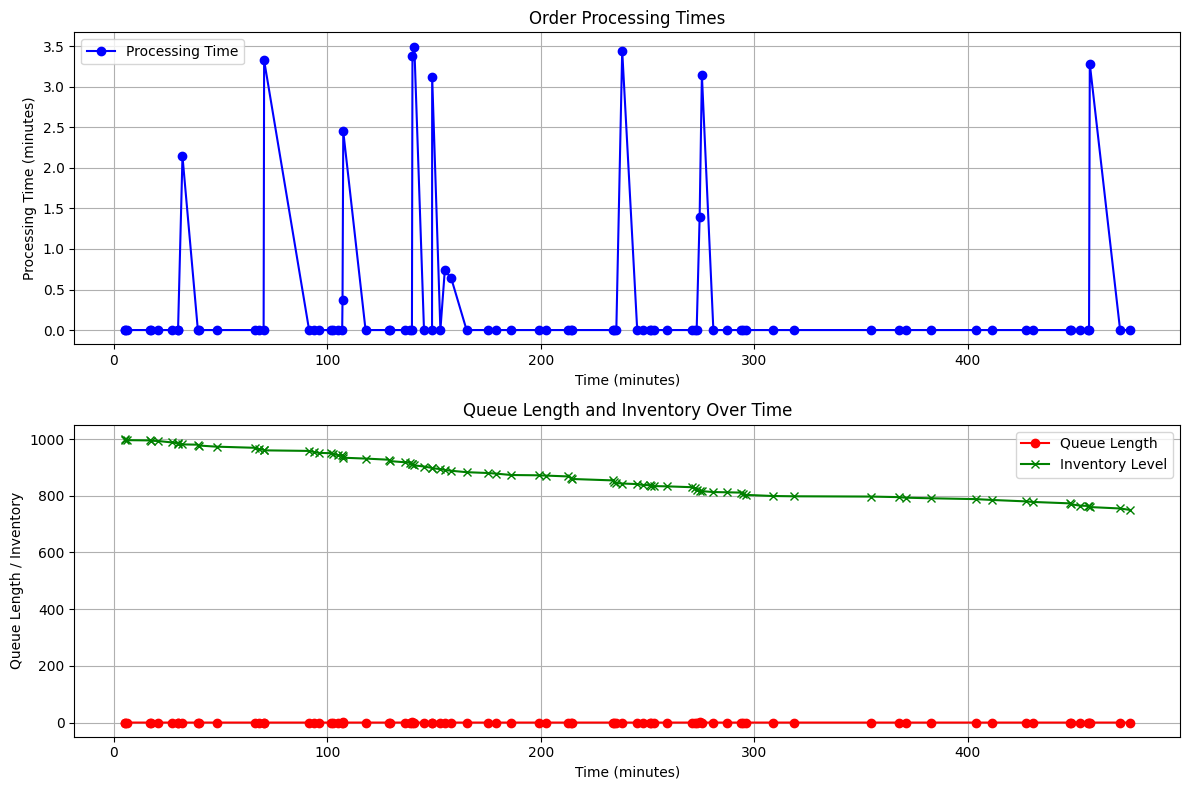

Timestamps: [5.1, 5.23, 5.98, 17.11, 17.28, 20.8, 27.09, 30.07, 30.1, 32.18, 39.39, 39.9, 48.13, 66.21, 67.95, 70.19, 70.43, 91.5, 93.89, 96.16, 101.7, 102.64, 105.03, 106.99, 107.15, 107.49, 117.95, 128.75, 129.5, 136.37, 138.92, 139.66, 139.91, 140.78, 145.31, 149.08, 149.14, 152.99, 155.07, 158.09, 165.27, 175.49, 179.03, 186.22, 199.0, 202.35, 212.9, 214.28, 214.73, 233.81, 234.5, 235.4, 238.15, 245.19, 247.73, 251.38, 251.71, 253.02, 259.17, 270.96, 272.32, 273.03, 274.42, 275.48, 280.86, 287.38, 293.9, 294.95, 295.97, 308.8, 318.49, 354.69, 367.73, 371.06, 382.7, 403.8, 411.49, 427.26, 430.59, 447.91, 448.23, 452.61, 456.4, 456.82, 457.17, 471.37, 475.89]
Processing Times: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37, 2.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.38, 3.5, 0.0, 0.0, 3.12, 0.0, 0.74, 0.64, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [4]:
# Import libraries
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
RANDOM_SEED = 42
SIM_TIME = 480  # Simulate for 480 minutes (8 hours)
NUM_WORKERS = 3  # Number of workers
ARRIVAL_RATE = 1/5  # Orders arrive every ~5 minutes (exponential distribution)
PROCESSING_TIME_MIN = 4  # Minimum processing time (minutes)
PROCESSING_TIME_MAX = 8  # Maximum processing time (minutes)
INITIAL_INVENTORY = 1000  # Initial items in inventory
RESTOCK_THRESHOLD = 100  # Restock when inventory falls below this
RESTOCK_AMOUNT = 500  # Items added during restock
RESTOCK_DELAY = 10  # Restock delay (minutes)
ITEMS_PER_ORDER_MIN = 1  # Minimum items per order
ITEMS_PER_ORDER_MAX = 5  # Maximum items per order
MAX_ORDERS = 100  # Limit to ensure completion

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Data tracking (module-level lists)
processing_times = []
queue_lengths = []
inventory_levels = []
timestamps = []

def order(env, name, worker, inventory):
    """Simulate an order being processed."""
    global processing_times, queue_lengths, inventory_levels, timestamps
    try:
        arrival_time = env.now
        # Check inventory
        items_needed = random.randint(ITEMS_PER_ORDER_MIN, ITEMS_PER_ORDER_MAX)
        if inventory.level < items_needed:
            print(f"{name} at {env.now:.2f}: Insufficient inventory ({inventory.level} < {items_needed})")
            return
        with worker.request() as req:
            yield req  # Wait for a worker
            # Record data after acquiring worker
            processing_time = env.now - arrival_time
            processing_times.append(processing_time)
            queue_lengths.append(len(worker.queue))
            inventory_levels.append(inventory.level)
            timestamps.append(arrival_time)
            print(f"{name} arrived at {arrival_time:.2f}, waited {processing_time:.2f} minutes")
            # Remove items from inventory
            yield inventory.get(items_needed)
            # Simulate processing time
            processing_duration = random.uniform(PROCESSING_TIME_MIN, PROCESSING_TIME_MAX)
            yield env.timeout(processing_duration)
            print(f"{name} processed in {processing_duration:.2f} minutes, left at {env.now:.2f}, inventory: {inventory.level}")
    except Exception as e:
        print(f"Error in order {name}: {e}")

def restock_inventory(env, inventory):
    """Restock inventory when below threshold."""
    try:
        while True:
            if inventory.level < RESTOCK_THRESHOLD:
                print(f"Inventory low at {env.now:.2f}: {inventory.level}. Initiating restock.")
                yield env.timeout(RESTOCK_DELAY)
                inventory.put(RESTOCK_AMOUNT)
                print(f"Restocked {RESTOCK_AMOUNT} items at {env.now:.2f}, new inventory: {inventory.level}")
            yield env.timeout(1)  # Check inventory every minute
    except Exception as e:
        print(f"Error in restock_inventory: {e}")

def order_generator(env, worker, inventory, max_orders):
    """Generate orders at random intervals."""
    try:
        order_id = 0
        while order_id < max_orders:
            inter_arrival_time = random.expovariate(ARRIVAL_RATE)
            if env.now + inter_arrival_time > SIM_TIME:
                break
            yield env.timeout(inter_arrival_time)
            env.process(order(env, f"Order{order_id}", worker, inventory))
            order_id += 1
        print(f"Generated {order_id} orders")
    except Exception as e:
        print(f"Error in order_generator: {e}")

def run_simulation():
    """Run the simulation with error handling."""
    try:
        # Validate parameters
        if NUM_WORKERS < 1:
            raise ValueError("NUM_WORKERS must be at least 1")
        if PROCESSING_TIME_MIN > PROCESSING_TIME_MAX:
            raise ValueError("PROCESSING_TIME_MIN cannot exceed PROCESSING_TIME_MAX")
        if ARRIVAL_RATE <= 0:
            raise ValueError("ARRIVAL_RATE must be positive")
        if SIM_TIME <= 0:
            raise ValueError("SIM_TIME must be positive")
        if INITIAL_INVENTORY < 0 or RESTOCK_THRESHOLD < 0 or RESTOCK_AMOUNT < 0:
            raise ValueError("Inventory parameters must be non-negative")
        if ITEMS_PER_ORDER_MIN > ITEMS_PER_ORDER_MAX:
            raise ValueError("ITEMS_PER_ORDER_MIN cannot exceed ITEMS_PER_ORDER_MAX")

        # Create environment and resources
        env = simpy.Environment()
        worker = simpy.Resource(env, capacity=NUM_WORKERS)
        inventory = simpy.Container(env, init=INITIAL_INVENTORY, capacity=INITIAL_INVENTORY + RESTOCK_AMOUNT * 10)
        env.process(order_generator(env, worker, inventory, MAX_ORDERS))
        env.process(restock_inventory(env, inventory))
        env.run(until=SIM_TIME)
        return True
    except Exception as e:
        print(f"Simulation failed: {e}")
        return False

def analyze_and_visualize():
    """Analyze and visualize results with safeguards."""
    global processing_times, queue_lengths, inventory_levels, timestamps
    try:
        # Verify data consistency
        lengths = [len(timestamps), len(processing_times), len(queue_lengths), len(inventory_levels)]
        if not all(l == lengths[0] for l in lengths):
            print(f"Warning: Array length mismatch - timestamps: {lengths[0]}, processing_times: {lengths[1]}, queue_lengths: {lengths[2]}, inventory_levels: {lengths[3]}")
            min_length = min(lengths)
            timestamps = timestamps[:min_length]
            processing_times = processing_times[:min_length]
            queue_lengths = queue_lengths[:min_length]
            inventory_levels = inventory_levels[:min_length]
            print(f"Trimmed arrays to length {min_length}")

        # Analyze results
        if processing_times:
            avg_processing_time = np.mean(processing_times)
            max_processing_time = np.max(processing_times)
            avg_queue_length = np.mean(queue_lengths)
            avg_inventory_level = np.mean(inventory_levels)
            print(f"\n\nAverage processing time: {avg_processing_time:.2f} minutes")
            print(f"Maximum processing time: {max_processing_time:.2f} minutes")
            print(f"Average queue length: {avg_queue_length:.2f} orders")
            print(f"Average inventory level: {avg_inventory_level:.2f} items")
        else:
            print("\n\nNo orders processed. Check simulation parameters.")
            return

        # Visualize with matplotlib
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(timestamps, processing_times, marker='o', color='b', label='Processing Time')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Processing Time (minutes)')
        plt.title('Order Processing Times')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(timestamps, queue_lengths, marker='o', color='r', label='Queue Length')
        plt.plot(timestamps, inventory_levels, marker='x', color='g', label='Inventory Level')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Queue Length / Inventory')
        plt.title('Queue Length and Inventory Over Time')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Print data for Chart.js
        print("Timestamps:", [round(t, 2) for t in timestamps])
        print("Processing Times:", [round(p, 2) for p in processing_times])
    except Exception as e:
        print(f"Visualization failed: {e}")

# Run the simulation and visualize results
if run_simulation():
    analyze_and_visualize()
else:
    print("Cannot visualize due to simulation failure.")